In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
# read in csv
df = pd.read_csv('Data Collection/combined_df.csv')

In [4]:
# separate data and target columns
target_cols = ['2012_voted_num', '2016_voted_num', '2020_voted_num', 
               '2012_voted_perc', '2016_voted_perc', '2020_voted_perc',
               '2012_early_vote_num', '2016_early_vote_num', '2020_early_vote_num',
               '2012_early_vote_perc', '2016_early_vote_perc', '2020_early_vote_perc',
               '2020_rep_vote_count', '2020_rep_vote_perc', '2020_dem_vote_count',
               '2020_dem_vote_perc', '2020_lib_vote_count', '2020_lib_vote_perc',
               '2020_grn_vote_count', '2020_grn_vote_perc', '2020_oth_vote_count',
               '2020_oth_vote_perc', '2020_votes_total', '2016_rep_vote_counte',
               '2016_rep_vote_perc', '2016_dem_vote_count', '2016_dem_vote_perc',
               '2016_lib_vote_count', '2016_lib_vote_perc', '2016_grn_vote_count',
               '2016_grn_vote_perc', '2016_oth_vote_count', '2016_oth_vote_perc',
               '2016_votes_total', '2012_rep_vote_perc', '2012_rep_vote_count',
               '2012_dem_vote_perc', '2012_dem_vote_count', '2012_oth_vote_perc',
               '2012_oth_vote_count', '2012_vote_total']

X = df.drop(columns = target_cols)

# isolate data by year
cols_2012 = [col for col in X.columns if '2012' in col]
cols_2012.insert(0,'county')
cols_2016 = [col for col in X.columns if '2016' in col]
cols_2016.insert(0,'county')
cols_2020 = [col for col in X.columns if '2020' in col]
cols_2020.insert(0,'county')


----
# Predicting Voter Turnout by County

This section creates a LASSO Regression Model predicting total voter turnout by county. The model is trained on data from 2012, and then applied to 2016 and 2020 data. 

In [5]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
y = df['2012_voted_num']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# fit Elastic Net model
el = ElasticNet(l1_ratio = 1, max_iter = 100000)
el.fit(X_train_2012, y_train_2012)
print(el.score(X_train_2012, y_train_2012))
print(el.score(X_test_2012, y_test_2012))

0.998380306225645
0.9926398589046923


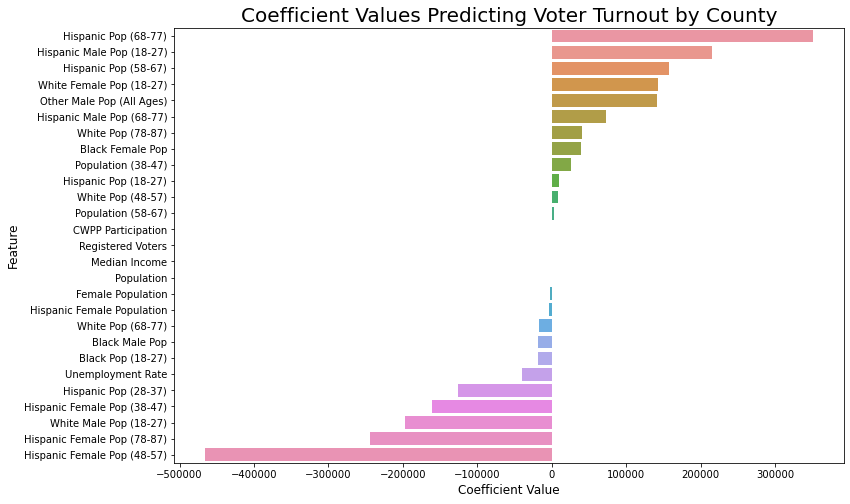

In [6]:
# plot coefficients
plt.figure(figsize = (12, 8))

# get data
betas = pd.DataFrame(el.coef_, columns=['betas'])
betas['Feature'] = X_2012.columns
data = betas[betas['betas'] != 0].sort_values(by='betas', ascending=False)

# plot and rename features
sns.barplot(data = data, y = 'Feature', x = 'betas', orient = 'h');
plt.yticks(ticks = range(27), labels = [
    'Hispanic Pop (68-77)', 
    'Hispanic Male Pop (18-27)',
    'Hispanic Pop (58-67)',
    'White Female Pop (18-27)',
    'Other Male Pop (All Ages)',
    'Hispanic Male Pop (68-77)',
    'White Pop (78-87)',
    'Black Female Pop',
    'Population (38-47)',
    'Hispanic Pop (18-27)',
    'White Pop (48-57)',
    'Population (58-67)',
    'CWPP Participation',
    'Registered Voters',
    'Median Income',
    'Population',
    'Female Population',
    'Hispanic Female Population',
    'White Pop (68-77)',
    'Black Male Pop',
    'Black Pop (18-27)',
    'Unemployment Rate',
    'Hispanic Pop (28-37)',
    'Hispanic Female Pop (38-47)',
    'White Male Pop (18-27)',
    'Hispanic Female Pop (78-87)',
    'Hispanic Female Pop (48-57)'
])
plt.title('Coefficient Values Predicting Voter Turnout by County', fontsize = 20)
plt.ylabel('Feature', fontsize = 12)
plt.xlabel('Coefficient Value', fontsize = 12);

In [7]:
def display_metrics(df, X, cols, target, est):
    X_year = X[cols]
    X_year.set_index('county', inplace = True)
    y = df[target]
    score = est.score(X_year, y)
    preds = est.predict(X_year)
    mse = mean_squared_error(y_true = y, y_pred = preds, squared = False)
    baseline_mse = mean_squared_error(y_true = y, y_pred = [y.mean()] * len(y), squared = False)
    reduced_error = 100 - (100*mse/baseline_mse)
    print('RMSE:          ', round(mse))
    print('Baseline RMSE: ', round(baseline_mse))
    print('Reduced Error: ', str(round(reduced_error, 2)) + '%')
    print('R2:            ', round(score,4))

In [8]:
display_metrics(df, X, cols_2012, '2012_voted_num', el)

RMSE:           4538
Baseline RMSE:  106338
Reduced Error:  95.73%
R2:             0.9982


In [9]:
display_metrics(df, X, cols_2016, '2016_voted_num', el)

RMSE:           6456
Baseline RMSE:  118386
Reduced Error:  94.55%
R2:             0.997


In [10]:
display_metrics(df, X, cols_2020, '2020_voted_num', el)

RMSE:           17773
Baseline RMSE:  147720
Reduced Error:  87.97%
R2:             0.9855


----
# Predicting Republican Voter Turnout by County
In this section we will get more specific with our target and train a model on 2012 data to predict voting totals for the Republican Presidential candidates.

In [102]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
X_2016 = X[cols_2016]
X_2016.set_index('county', inplace = True)
X_2020 = X[cols_2020]
X_2020.set_index('county', inplace = True)
y = df['2012_rep_vote_count']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# Conduct Gridsearch on ElasticNet

pipe_params = {
    'alpha': [327.75],
    'l1_ratio': [1]
}
gs_r = GridSearchCV(ElasticNet(max_iter = 100_000), pipe_params, cv = 3, verbose=1)
gs_r.fit(X_train_2012, y_train_2012)
print(gs_r.score(X_train_2012, y_train_2012))
print(gs_r.score(X_test_2012, y_test_2012))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0.9661729636883134
0.918458871251818


In [103]:
display_metrics(df, X, cols_2012, '2012_rep_vote_count', gs)

RMSE:           13667
Baseline RMSE:  53111
Reduced Error:  74.27%
R2:             0.9338


In [104]:
display_metrics(df, X, cols_2012, '2016_rep_vote_counte', gs)


RMSE:           15915
Baseline RMSE:  51047
Reduced Error:  68.82%
R2:             0.9028


In [105]:
display_metrics(df, X, cols_2012, '2020_rep_vote_count', gs_r)

RMSE:           18894
Baseline RMSE:  64284
Reduced Error:  70.61%
R2:             0.9136


----
# Predicting Democrat Voter Turnout by County
In this section we will get more specific with our target and train a model on 2012 data to predict voting totals for the Democrat Presidential candidates.

In [106]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
X_2016 = X[cols_2016]
X_2016.set_index('county', inplace = True)
X_2020 = X[cols_2020]
X_2020.set_index('county', inplace = True)
y = df['2012_dem_vote_count']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# Conduct Gridsearch on ElasticNet

pipe_params = {
    'alpha': [990],
    'l1_ratio': [1]
}
gs_d = GridSearchCV(ElasticNet(max_iter = 100_000), pipe_params, cv = 5, verbose=1)
gs_d.fit(X_train_2012, y_train_2012)
print(gs_d.score(X_train_2012, y_train_2012))
print(gs_d.score(X_test_2012, y_test_2012))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9799001647358815
0.9324870708706102


In [107]:
display_metrics(df, X, cols_2012, '2012_dem_vote_count', gs_d)

RMSE:           7859
Baseline RMSE:  53499
Reduced Error:  85.31%
R2:             0.9784


In [108]:
display_metrics(df, X, cols_2016, '2016_dem_vote_count', gs_d)

RMSE:           13784
Baseline RMSE:  64366
Reduced Error:  78.58%
R2:             0.9541


In [109]:
display_metrics(df, X, cols_2020, '2020_dem_vote_count', gs_d)

RMSE:           28400
Baseline RMSE:  86318
Reduced Error:  67.1%
R2:             0.8917


----
# Could we predict who won in 2016?

In [126]:
dem_2016_pred = round(gs_d.predict(X_2016).sum())

In [127]:
dem_2016_true = df['2016_dem_vote_count'].sum()

In [128]:
rep_2016_pred = round(gs_r.predict(X_2016).sum())

In [129]:
rep_2016_true = df['2016_rep_vote_counte'].sum()

In [155]:
value = ['Predicted', 'True', 'Predicted', 'True']
votes = [rep_2016_pred, rep_2016_true, dem_2016_pred, dem_2016_true]
party = ['Republican', 'Republican', 'Democrat', 'Democrat']
elect_2016 = pd.DataFrame(votes, columns=['Votes'])
elect_2016['Party'] = party
elect_2016['Value'] = value

In [156]:
elect_2016

,Votes,Party,Value
0,4844530,Republican,Predicted
1,4685047,Republican,True
2,3630790,Democrat,Predicted
3,3877868,Democrat,True


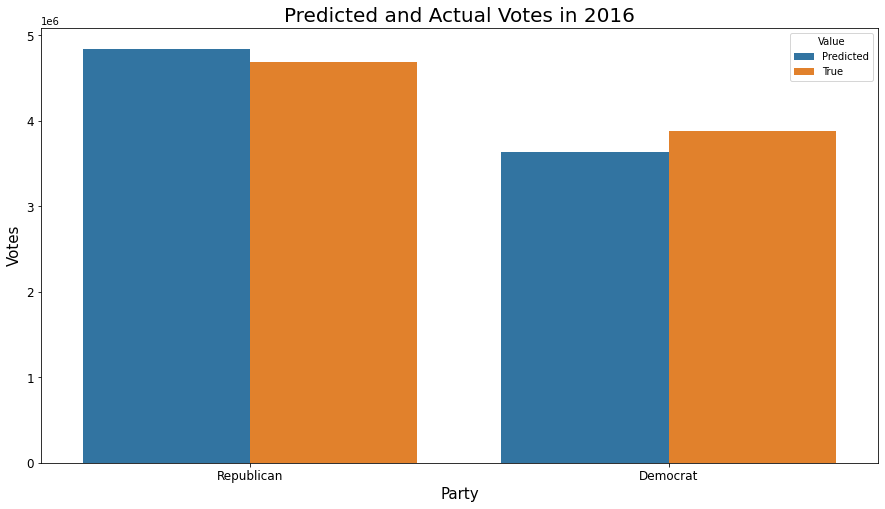

In [171]:
plt.figure(figsize = (15, 8))
sns.barplot(data=elect_2016, x = 'Party', y = 'Votes', hue = 'Value')
plt.xticks(fontsize = 12)
plt.xlabel('Party', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Votes', fontsize = 15)
plt.title('Predicted and Actual Votes in 2016', fontsize = 20);

# Could we predict who won in 2020?

In [172]:
dem_2020_pred = round(gs_d.predict(X_2020).sum())

In [173]:
dem_2020_true = df['2020_dem_vote_count'].sum()

In [174]:
rep_2020_pred = round(gs_r.predict(X_2020).sum())

In [176]:
rep_2020_true = df['2020_rep_vote_count'].sum()

In [177]:
value = ['Predicted', 'True', 'Predicted', 'True']
votes = [rep_2020_pred, rep_2020_true, dem_2020_pred, dem_2020_true]
party = ['Republican', 'Republican', 'Democrat', 'Democrat']
elect_2020 = pd.DataFrame(votes, columns=['Votes'])
elect_2020['Party'] = party
elect_2020['Value'] = value

In [178]:
elect_2020

,Votes,Party,Value
0,5382272,Republican,Predicted
1,5890347,Republican,True
2,3866803,Democrat,Predicted
3,5259126,Democrat,True


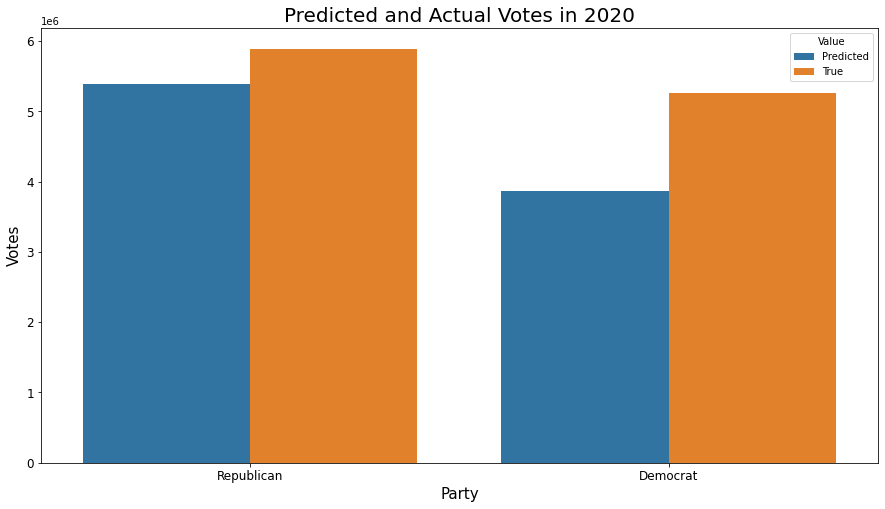

In [179]:
plt.figure(figsize = (15, 8))
sns.barplot(data=elect_2020, x = 'Party', y = 'Votes', hue = 'Value')
plt.xticks(fontsize = 12)
plt.xlabel('Party', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Votes', fontsize = 15)
plt.title('Predicted and Actual Votes in 2020', fontsize = 20);